<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/feature_extractor_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# copy the filters from ex7
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color

In [1]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)

In [3]:
# preprocess and pipeline

def grayscale_preprocessing(img):
  if np.max(img)>1:
    img = img.astype(np.float32)/255.0
  im_gray = np.mean(img, axis=2)
  return im_gray

def bilateral_preprocessing(img, ksize, sigmX, sigmY):
  bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
  return bilateral_filtered_image

def high_pass_preprocessing(img, ksize, sig):
  low_pass = cv2.GaussianBlur(img, ksize, 0)
  high_pass = img - low_pass
  return high_pass

def sobel_preprocessing(img, ksize):
  sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize) # Find x and y gradients
  sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  magnitude = magnitude / np.max(magnitude) # normalize
  return magnitude

def gaussian_blur_preprocessing(img, ksize, sigma):
  blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
  return blurred_im

def canny_filter(img, high_threshold, low_threshold):
  # ensure the image is normalized to the range [0, 1]
  img = img / np.max(img)
  # scale the image to the range [0, 255] and convert to 8-bit
  img_8u = np.uint8(img * 255)
  # threshold the image and get the interesting points
  # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
  # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
  # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

  im_threshold = cv2.Canny(image=img_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
  im_threshold = im_threshold / np.max(im_threshold) # normalize
  return im_threshold

def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]


def histogram_clipping(img, threshold_value):
  clipped_image = img.copy()
  # before
  # draw_histogram_gray(clipped_image)
  clipped_image[img < threshold_value/255.0] = 0
  # Normalize the clipped_image to 0-255 for proper histogram visualization
  normalized_clipped_image = cv2.normalize(clipped_image, None, alpha=0, beta=255,
                                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  # draw_histogram_gray(clipped_image)
  return normalized_clipped_image

def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
  block_norm = 'L1'  # Block normalization method
  # orientations = 9   # Number of orientation bins
  # pixels_per_cell = (8, 8)  # Size of the cell
  # cells_per_block = (3, 3)  # Size of the block

  # Compute the HOG features
  hog_features, hog_image = feature.hog(img_gray,
                                        orientations=orientations,
                                        pixels_per_cell=pixels_per_cell,
                                        cells_per_block=cells_per_block,
                                        block_norm=block_norm,
                                        visualize=True)
  return hog_features, hog_image

def preprocess_1(df):
  image_dir = df['path'] # ignore index
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_sobel = sobel_preprocessing(im_bilateral, 31)
    im_canny = canny_filter(im_blurred, 70, 0)
    im_cropped = crop_center(im_canny, 252, 252)
    im_flattened = im_cropped.flatten()
    preprocessed_list.append(im_flattened)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed

def preprocess_2(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 240, 240)
    hog_feature, hog_image = hog(im_cropped) #(63504,)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(hog_feature)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed


def preprocess_resnet(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 224, 224)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(im_cropped)

  return preprocessed_list

In [4]:
def display_img_colorbar(img):
  # display the points
  fig, ax = plt.subplots(figsize=(8, 6))
  im_ax = plt.imshow(img, cmap='gray')
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im_ax, cax=cax)
  plt.show()

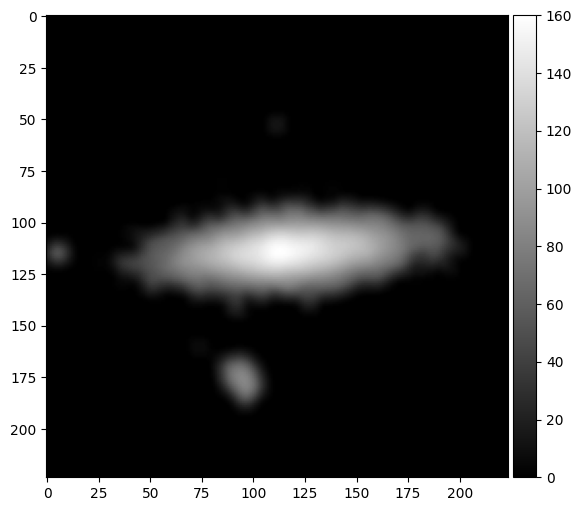

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = preprocess_resnet(df_train[:10])[9]
display_img_colorbar(img)

In [46]:
images_list = preprocess_resnet(df_train)

In [47]:
len(images_list)

2000

In [45]:
import torch
import torchvision.models as models

# load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)

# remove the classifier on top of resnet
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
# freeze the parameters of the feature extractor
for param in resnet.parameters():
    param.requires_grad = False
# Print the modified ResNet architecture

print(resnet)

# move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [48]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# data loader
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        return img

# transformations to be applied to the images
transform = transforms.Compose([
    # crop the image to shape of 224,224 in preprocess stage
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

# function to preprocess an image
def preprocess_images(images):
    processed_images = []
    for img in images:
        img = Image.fromarray(img)
        processed_image = transform(img).unsqueeze(0)  # Add batch dimension
        processed_images.append(processed_image)
    return processed_images


custom_dataset = CustomDataset(images_list, transform=transform)

# create a data loader with batch size
batch_size = 8
data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

# Process images in batches
features_list = []
with torch.no_grad():
    for batch in data_loader:
        features = resnet(batch.to(device))
        features_list.append(features)

# Concatenate features from all batches
features = torch.cat(features_list, dim=0)

print(features.shape)

torch.Size([2000, 2048, 1, 1])


In [49]:
import pandas as pd

features = features.cpu()
# reshape it to 2000,2048
reshaped_features = features.squeeze().numpy()
reshaped_features = reshaped_features.reshape(reshaped_features.shape[0], -1)

# Convert to DataFrame
df_features = pd.DataFrame(reshaped_features)

# Display the DataFrame
df_features.head(3)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.401463,0.372468,0.655118,0.877904,0.358098,0.944786,0.515035,0.729580,0.302691,0.682692,...,0.402030,0.411964,0.207842,0.436925,0.255212,0.237233,0.106093,0.342897,0.315254,0.461465
1,0.360605,0.406355,0.118738,0.450485,0.594651,0.377840,0.188658,0.858380,0.259015,0.551912,...,0.544827,0.634633,0.139175,0.442149,0.803943,0.142635,0.801764,0.327790,0.304544,0.368697
2,0.493411,1.168011,0.600957,0.355534,0.451212,1.179167,0.342881,0.338718,0.290492,0.144250,...,0.425192,0.657497,0.249852,0.698523,0.138570,0.065181,1.216596,0.382186,0.103836,0.334787


In [50]:
df_features.shape

(2000, 2048)

In [51]:
df_features.to_csv('/content/drive/MyDrive/galaxy_zoo/df_train_reduced_processed_resnet', index=False)

In [52]:
from sklearn.decomposition import PCA

def pick_top_feature_pca_train(feature_matrix, top_components):
#pick up top 100 features by PCA
  pca = PCA(n_components=500)
  pca.fit(feature_matrix)
  principal_components = pca.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]

  plt.figure(figsize=(8, 4))
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('Number of PCA components')
  plt.ylabel('Cumulative explained variance')
  plt.title('Explained Variance vs Number of PCA Components')
  plt.grid(True)
  plt.show()
  # Extract the top n components
  return top_components_matrix, pca

# use the pca embedding from train and process the val and test
def pick_top_feature_pca_val_test(pca_train, feature_matrix, top_components: int):
  principal_components = pca_train.transform(feature_matrix)
  top_components_matrix = principal_components[:, :top_components]
  return top_components_matrix

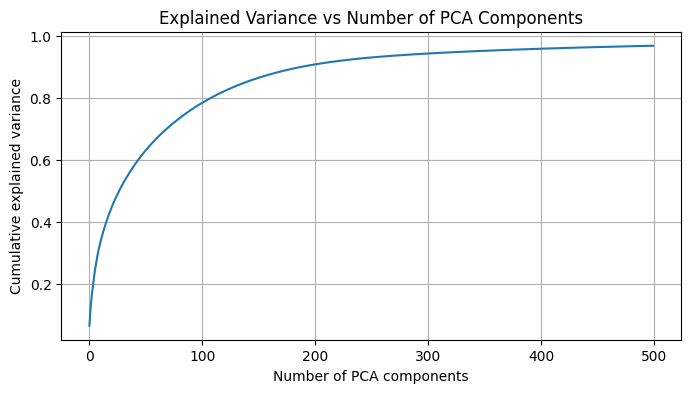

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-1.704050,1.681727,3.238689,-1.176461,0.395956,1.420435,-1.990516,-0.420615,-0.926979,-0.024088,...,0.328862,-0.385087,-0.240175,-0.634789,0.373744,-0.039904,-0.139187,-0.323274,-0.191494,0.293944
1,4.544971,-0.372772,-1.120736,1.694265,3.652446,3.706774,0.206212,-0.209262,0.052613,0.788925,...,0.138297,-0.470792,0.018734,0.222286,0.433564,0.043882,-0.118413,0.105470,0.133443,-0.303845
2,-1.814491,0.978902,1.742219,-1.315318,-1.709590,-2.400024,1.843103,-0.101640,-0.293089,1.438920,...,0.287594,-0.283579,0.535294,-0.402442,-0.099685,0.003902,0.283908,0.160948,0.149461,0.237891


In [53]:
train_features = df_features.values
top_components = 200
pca_train_features, pca_train_resnet = pick_top_feature_pca_train(train_features, top_components)

# Convert PCA transformed features to DataFrame
df_top_pca_resnet = pd.DataFrame(pca_train_features)
df_top_pca_resnet.head(3)

In [54]:
# feature normarlization since we only pick up top 200. z score normalization

from sklearn.preprocessing import StandardScaler

def feature_normalization(df_feature):
  scaler = StandardScaler()
  normalized_features = scaler.fit_transform(df_feature.values)
  df_normalized = pd.DataFrame(normalized_features, columns=df_feature.columns)
  return df_normalized

In [55]:
df_top_pca_resnet_pca_normalized = feature_normalization(df_top_pca_resnet)
df_top_pca_resnet_pca_normalized.head(5)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.613000,0.638197,1.549016,-0.611942,0.214818,0.797776,-1.228119,-0.269813,-0.626258,-0.017535,...,1.148114,-1.345816,-0.844222,-2.242947,1.327650,-0.143499,-0.503690,-1.183950,-0.704266,1.089700
1,1.634968,-0.141463,-0.536031,0.881280,1.981563,2.081881,0.127230,-0.134236,0.035545,0.574308,...,0.482818,-1.645343,0.065850,0.785417,1.540147,0.157805,-0.428514,0.386269,0.490768,-1.126407
2,-0.652729,0.371482,0.833277,-0.684169,-0.927504,-1.347955,1.137167,-0.065199,-0.198008,1.047480,...,1.004042,-0.991062,1.881573,-1.421977,-0.354110,0.014032,1.027408,0.589451,0.549680,0.881904
3,-0.086275,-0.575668,0.046285,1.139156,-1.300293,-1.255369,0.990103,-0.610887,1.554118,1.782756,...,2.692079,0.926707,-0.055387,1.741910,0.455722,1.053882,-0.753902,0.728116,0.256106,-0.752392
4,1.007538,1.605956,-2.780709,-0.986274,-1.328878,0.558130,1.292538,-0.370024,0.347502,-1.374274,...,-2.874351,1.503628,0.086718,-0.766622,-3.152611,0.930015,-1.688848,0.530192,1.024499,-0.672286


In [57]:
df_top_pca_resnet_pca_normalized.to_csv('/content/drive/MyDrive/galaxy_zoo/df_train_reduced_processed_resnet_pca200_normalized', index=False)

In [58]:
df_train_resnet = pd.concat([df_train, df_top_pca_resnet_pca_normalized], axis=1)
print(df_train_resnet.shape)

df_train_resnet_nopca_nonorml = pd.concat([df_train, df_features], axis=1)
print(df_train_resnet_nopca_nonorml.shape)

(2000, 203)
(2000, 2051)


classifier LDA + logistic

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

X = df_train_resnet.drop(['path', 'index', 'label'], axis=1)  # features
y = df_train_resnet['label'] # label

# split the data here (need to circle back and use the actual testing data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA to reduce the dimension to number of class - 1
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

#logistic regression as the classifer in the space of LDA space
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Logistic Regression with L1 regularization
# [0.001, 0.01, 0.1, 1]
classifier_l1 = LogisticRegression(penalty='l1', C=1 , solver='liblinear')
classifier_l1.fit(X_train_lda, y_train)

# Logistic Regression with L2 regularization
# C [0.1, 1, 10, 100]
classifier_l2 = LogisticRegression(penalty='l2', C=100)
classifier_l2.fit(X_train_lda, y_train)

# transform the test data to the LDA feature space and make predictions
X_test_lda = lda.transform(X_test)
y_pred = classifier.predict(X_test_lda)

# evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print("validation accuracy:", accuracy)

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Assess Overfitting
# To assess overfitting, you can compare the performance on the training set and test set.
# If the model performs significantly better on the training set compared to the test set, it may be overfitting.
train_accuracy = accuracy_score(y_train, classifier.predict(X_train_lda))
print("Training Accuracy:", train_accuracy)
train_accuracy_l1 = accuracy_score(y_train, classifier_l1.predict(X_train_lda))
train_accuracy_l2 = accuracy_score(y_train, classifier_l2.predict(X_train_lda))

print("Training Accuracy with L1 Regularization:", train_accuracy_l1)
print("Training Accuracy with L2 Regularization:", train_accuracy_l2)

validation accuracy: 0.05
Confusion Matrix:
[[ 1 20 10 38 14]
 [13  3 19 19 23]
 [19 25  5 17 16]
 [16 11 13  6 22]
 [12 31 18 24  5]]
Training Accuracy: 0.325
Training Accuracy with L1 Regularization: 0.324375
Training Accuracy with L2 Regularization: 0.324375


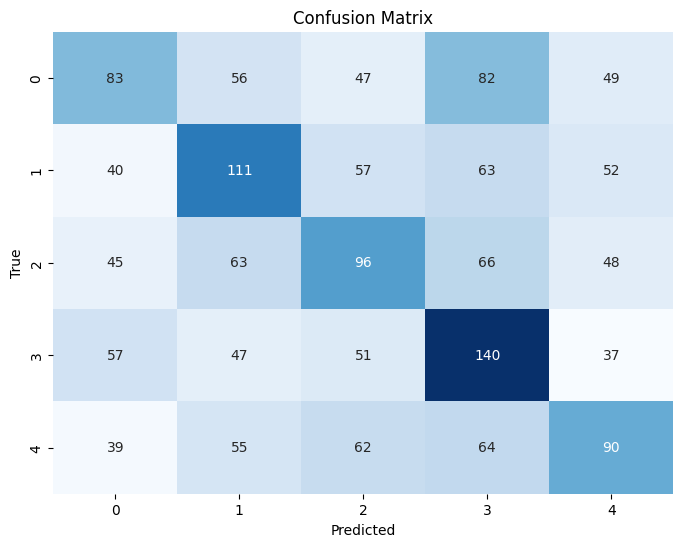

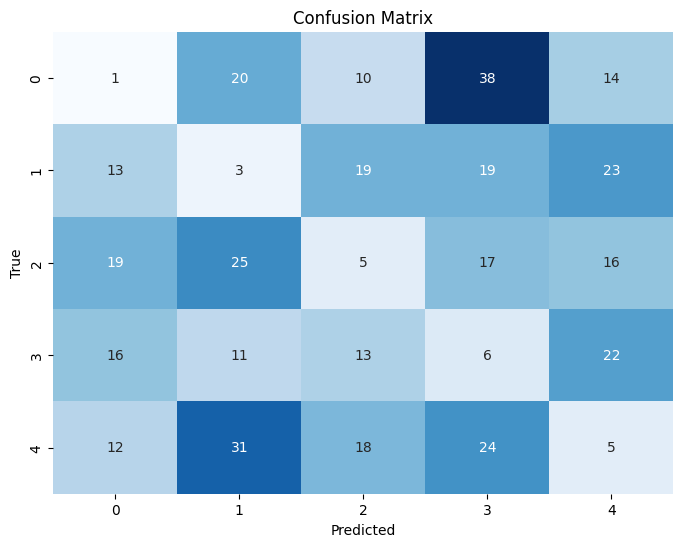

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
conf_matrix_val = confusion_matrix(y_test, y_pred)
conf_matrix_train = confusion_matrix(y_train, classifier.predict(X_train_lda))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Try NN